In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,precision_recall_curve,average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

from tools import *

In [2]:
db = pd.read_csv("data/player_stats_extended.csv")
db = db_to_numeric(db)
#create binary value for injured or not
db['INJURY_OCCURRED'] = db['INJURED_TYPE'].notna().astype(int)

features = [
    'AGE', 'PLAYER_HEIGHT_INCHES', 'PLAYER_WEIGHT', 'GP', 'MIN', 
    'USG_PCT', 'PACE', 'POSS', 'FGA_PG', 'DRIVES', 'DRIVE_FGA', 
    'DRIVE_PASSES', 'DIST_MILES', 'AVG_SPEED', 'PULL_UP_FGA', 
    'PULL_UP_FG3A', 'TOUCHES', 'FRONT_CT_TOUCHES', 'AVG_SEC_PER_TOUCH',
    'AVG_DRIB_PER_TOUCH', 'ELBOW_TOUCHES', 'POST_TOUCHES', 'PAINT_TOUCHES'
]

# Create feature matrix and target vector
X = db[features]
y = db['INJURY_OCCURRED']


In [3]:
# Handle missing values in features (non-injury cases)
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Standardize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

In [4]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)
injured_ratio = y.mean()
print(f"Injury rate: {injured_ratio:.2%}")
print(f"Non-Injured vs Injured: {np.bincount(y)}")


Injury rate: 21.76%
Non-Injured vs Injured: [4364 1214]


In [5]:
# Calculate class weights for imbalance
from sklearn.utils.class_weight import compute_class_weight
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

# Initialize and train model
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=8,
    min_samples_split=5,
    class_weight=class_weights,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

rf_model.fit(X_train, y_train)
train_predictions = rf_model.predict(X_train)
print("Unique classes predicted:", np.unique(train_predictions))

Unique classes predicted: [0 1]


              precision    recall  f1-score   support

           0       0.91      0.73      0.81       873
           1       0.43      0.75      0.55       243

    accuracy                           0.73      1116
   macro avg       0.67      0.74      0.68      1116
weighted avg       0.81      0.73      0.75      1116



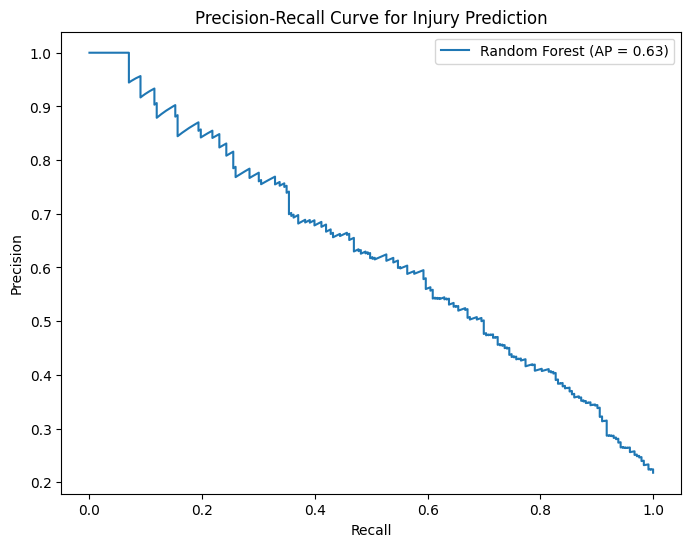

In [6]:
# Predict probabilities
y_probs = rf_model.predict_proba(X_test)[:, 1]

# Classification report
print(classification_report(y_test, rf_model.predict(X_test)))

# Precision-Recall curve (better than ROC for imbalanced data)
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
ap_score = average_precision_score(y_test, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Random Forest (AP = {ap_score:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Injury Prediction')
plt.legend()
plt.show()

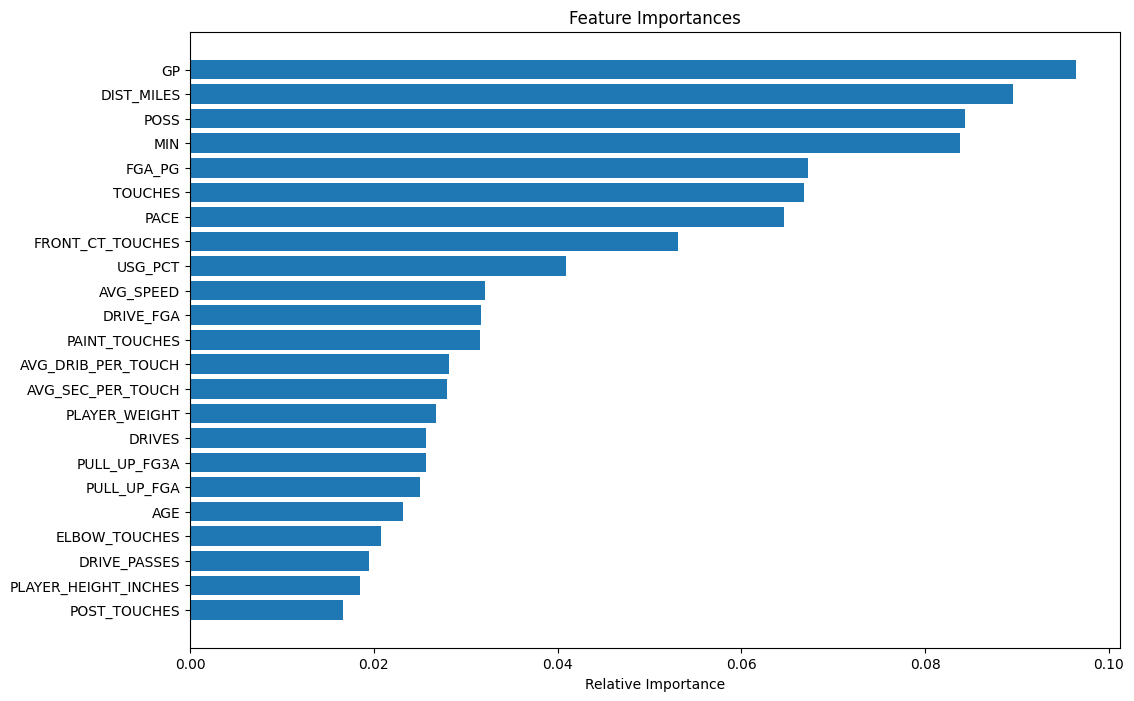

In [7]:
# Get feature importances
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot
plt.figure(figsize=(12, 8))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.gca().invert_yaxis()  # Most important at top
plt.xlabel('Relative Importance')
plt.show()